In [26]:
# Sumber: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [27]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

/home/ardi/anaconda3/envs/cpy3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


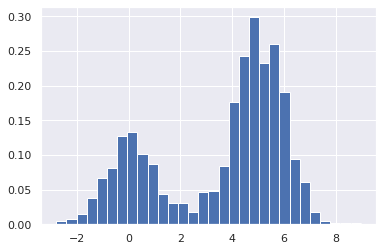

In [28]:
hist = plt.hist(x, bins=30, normed=True)

In [29]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [30]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

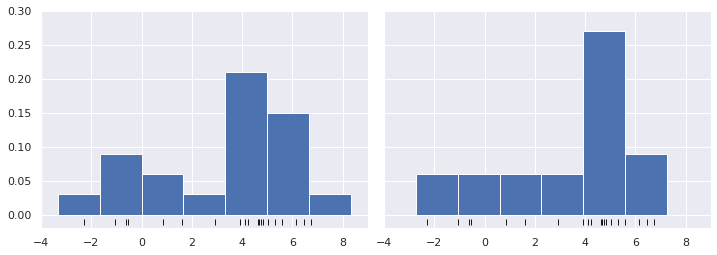

/home/ardi/anaconda3/envs/cpy3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


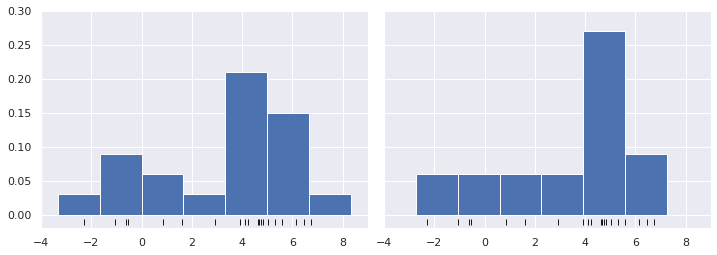

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)
    

(-0.2, 8)

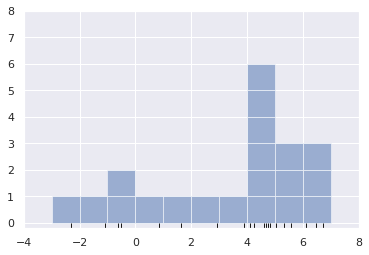

In [33]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

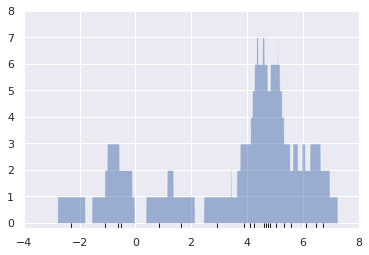

In [34]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

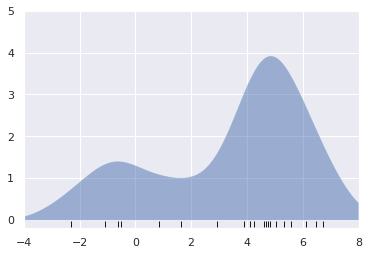

In [35]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

(-0.02, 0.22)

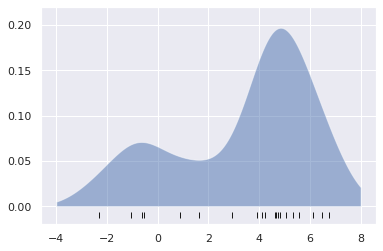

In [39]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])
# print(" logprob = ", logprob)
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

In [43]:
from hw5.libs.common.dataset import Dataset
dataset = Dataset(train_data=80, test_data=20)
# dataset = Dataset(train_data=20, test_data=10)
X_train, Y_train, X_test, Y_test = dataset.get_dataset()

In [44]:
from sklearn.decomposition import PCA
print("sebelum PCA = ", X_train.shape)
# Dimensional reduction
# pca = PCA(n_components=2, whiten=False)
pca = PCA(n_components=64, whiten=False)
X_train = pca.fit_transform(X_train)
print("setelah PCA = ", X_train.shape)


sebelum PCA =  (80, 784)
setelah PCA =  (80, 64)


In [45]:
new_x = []
for i in range(len(Y_train)):
    if int(Y_train[i]) == 1:
        print("i=", i, "; label = ", Y_train[i])
        new_x.append(X_train[i])
new_x = np.asarray(new_x)
print(new_x.shape)

i= 3 ; label =  1
i= 6 ; label =  1
i= 8 ; label =  1
i= 14 ; label =  1
i= 23 ; label =  1
i= 24 ; label =  1
i= 40 ; label =  1
i= 59 ; label =  1
i= 67 ; label =  1
i= 70 ; label =  1
i= 72 ; label =  1
i= 77 ; label =  1
i= 78 ; label =  1
(13, 64)


In [46]:
# Too wide a bandwidth leads to a high-bias estimate -> under-fitting
# too narrow a bandwidth leads to a high-variance estimate -> over-fitting
# KernelDensity = estimator in Scikit-Learn
# GridSearchCV = to optimize the bandwidth for the preceding dataset
# small dataset = use leave-one-out cross-validation
# from sklearn.grid_search import GridSearchCV
# from sklearn.cross_validation import LeaveOneOut
'''
How does it works:
1. KernelDensity() is simply estimating the density of the given data
    - it places a Gaussian on each data point and then sum up all of these Gaussians
    - When normalizing by the number of data points, this should yield the PDF. 
2. GridSearchCV is an algorithm that selects the optimal bandwidth of the Gaussians 
   that KernelDensity() is going to use.
    - To achieve this, GridSearchCV tries out a certain bandwidth, and
    - lets KernelDensity() estimate the pdf using K-1 folds
    - It then tests how good the KDE is on the last fold by computing the log-likelihood.
    - NB: GridSearchCV does this K times and averages the likelihood. 
'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

'''
cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
'''
x = new_x[0]
loo = LeaveOneOut()
cv_loo = loo.get_n_splits(x)
# cv_loo = 5
print(" > x = ", x)
print(" > x.shape = ", x.shape)
print(" > cv_loo = ", cv_loo)

 > x =  [-2.9735963   0.9978679  -3.618462    0.17139332 -0.83749354  2.2784007
 -0.0249908  -1.1259627   1.0590577  -0.311671    1.4666175   0.41142216
  0.01468537 -0.6657214   0.37863052  0.01775272  0.53027076  0.5848272
  0.22810416  0.32193846  0.06176328 -0.30456975 -0.6118476  -0.19279742
 -0.22396009 -0.11869791  0.56150365  0.14049566 -0.10426056  0.28396764
 -0.10018364  0.01288238 -0.48101673 -0.22166687 -0.1837322  -0.09483784
  0.08208001  0.38694283 -0.17899545 -0.17352541 -0.24935254  0.03941406
 -0.01321203 -0.11219025  0.18765545 -0.06005318  0.11723461  0.09813312
 -0.40010798  0.24062043 -0.37130678  0.13619255 -0.02501635 -0.13701713
  0.42963496 -0.11095937 -0.21604227 -0.07823046 -0.01323702 -0.07472643
 -0.11758597  0.2675856  -0.14287065  0.1067035 ]
 > x.shape =  (64,)
 > cv_loo =  64


In [47]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
print(" > bandwidths = ", bandwidths)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=cv_loo)
grid.fit(x[:, None]);

 > bandwidths =  [ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  4.1320124

In [48]:
grid.best_params_

{'bandwidth': 0.33516026509388425}

In [52]:
bw = []
for i in range(len(new_x)):
    x = new_x[i]
    
    loo = LeaveOneOut()
    cv_loo = loo.get_n_splits(x)
    # cv_loo = 5
    # print(" > x = ", x)
    # print(" > x.shape = ", x.shape)
    # print(" > cv_loo = ", cv_loo)

    bandwidths = 10 ** np.linspace(-1, 1, 100)
    # print(" > bandwidths = ", bandwidths)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=cv_loo)
    grid.fit(x[:, None])

    print("BEST GRID = ", grid.best_params_)
    bw.append(float(grid.best_params_["bandwidth"]))
print("AVG Bandwidth = ", np.average(bw))

BEST GRID =  {'bandwidth': 0.33516026509388425}
BEST GRID =  {'bandwidth': 0.4430621457583881}
BEST GRID =  {'bandwidth': 0.40370172585965547}
BEST GRID =  {'bandwidth': 0.36783797718286343}
BEST GRID =  {'bandwidth': 0.29150530628251775}
BEST GRID =  {'bandwidth': 0.464158883361278}
BEST GRID =  {'bandwidth': 0.4229242874389499}
BEST GRID =  {'bandwidth': 0.40370172585965547}
BEST GRID =  {'bandwidth': 0.36783797718286343}
BEST GRID =  {'bandwidth': 0.6135907273413174}
BEST GRID =  {'bandwidth': 0.40370172585965547}
BEST GRID =  {'bandwidth': 0.4229242874389499}
BEST GRID =  {'bandwidth': 0.2782559402207124}
AVG Bandwidth =  0.401412536529284


In [53]:
print("AVG Bandwidth = ", np.average(bw))
print("MEAN Bandwidth = ", np.mean(bw))

AVG Bandwidth =  0.401412536529284
MEAN Bandwidth =  0.401412536529284


In [50]:
# new_x.shape
bandwidths = 10 ** np.linspace(-1, 1, 100)
# print(" > bandwidths = ", bandwidths)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=cv_loo)
grid.fit(new_x[:, None])

print("BEST GRID = ", grid.best_params_)


ValueError: Cannot have number of splits n_splits=64 greater than the number of samples: n_samples=13.

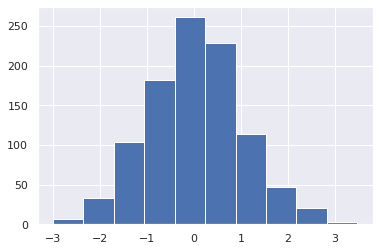

In [59]:
# example of plotting a histogram of a random sample
from matplotlib import pyplot
from numpy.random import normal
# generate a sample
sample = normal(size=1000)
# plot a histogram of the sample
pyplot.hist(sample, bins=10)
pyplot.show()



(1000,)


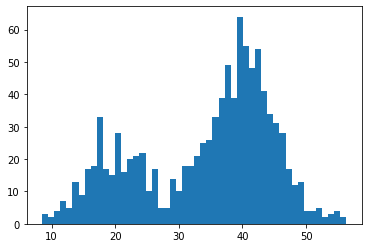

In [8]:
# Source: https://machinelearningmastery.com/probability-density-estimation/
# example of kernel density estimation for a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

# example of a bimodal data sample
# from matplotlib import pyplot
# from numpy.random import normal
# from numpy import hstack
# generate a sample
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
print(sample.shape)
# plot the histogram
pyplot.hist(sample, bins=50)
pyplot.show()

In [78]:
# fit density
model = KernelDensity(bandwidth=1, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)

KernelDensity(algorithm='auto', atol=0, bandwidth=1, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [87]:
# sample probabilities for a range of outcomes
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
print("> probabilities model = ", probabilities)
probabilities = exp(probabilities)
print("> probabilities exp = ", probabilities)

> probabilities model =  [-25.56336367 -20.01001806 -15.45030711 -11.88338319  -9.30629446
  -7.70264074  -6.97578472  -6.7098363   -6.31524807  -5.82867493
  -5.41098118  -5.08586516  -4.77156435  -4.46175968  -4.18694466
  -3.94361104  -3.7949371   -3.7301037   -3.74225778  -3.82472529
  -3.93745607  -3.96082496  -3.92380477  -3.98690495  -4.14078913
  -4.30926507  -4.42000305  -4.45323993  -4.35053219  -4.26405933
  -4.22193375  -4.0904138   -3.80507569  -3.51159547  -3.34784023
  -3.18299159  -2.98834993  -2.88192439  -2.85999993  -2.9335181
  -3.05485154  -3.13189795  -3.23952935  -3.37183427  -3.42014596
  -3.47445413  -3.73002038  -4.13903672  -4.48072298  -4.74222226
  -5.06373822  -5.63475586  -6.26770837  -6.75766356  -7.66616615
  -9.35913535 -11.938045   -15.44871675 -19.92049124]
> probabilities exp =  [7.90628049e-12 2.04060795e-09 1.94992038e-07 6.90418233e-06
 9.08505731e-05 4.51632961e-04 9.34232966e-04 1.21886364e-03
 1.80851706e-03 2.94197272e-03 4.46725490e-03 6.183

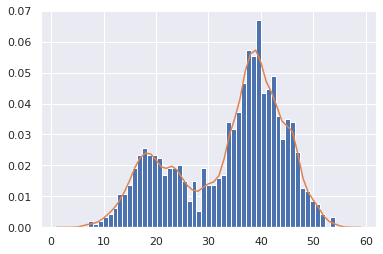

In [89]:
# plot the histogram and pdf
pyplot.hist(sample, bins=50, density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()

In [4]:
from hw5.libs.common.dataset import Dataset
from hw5.libs.common.util import int_to_tuple, save_to_csv
from hw5.libs.algo.KDEClassifier import KDEClassifier
from datetime import datetime
import matplotlib.pyplot as plt

In [5]:
dataset = Dataset(train_data=80, test_data=20)
# dataset = Dataset()
X_train, Y_train, X_test, Y_test = dataset.get_dataset()

In [25]:
print("sebelum PCA = ", X_train.shape)
# Dimensional reduction
# pca = PCA(n_components=2, whiten=False)
pca = PCA(n_components=64, whiten=False)
X_train = pca.fit_transform(X_train)
print("setelah PCA = ", X_train.shape)

sebelum PCA =  (80, 784)


NameError: name 'PCA' is not defined

In [59]:
# Collect only digit=1
idxs = [12, 3, 6, 14, 23, 24, 40, 59, 67]
digit_ones = []
for idx in idxs:
    digit_ones.append(X_train[idx])

In [79]:
idx_d1_tests = [67, 70, 72, 77, 78]
digit_ones_test = []
for idx in idx_d1_tests:
    digit_ones_test.append(X_train[idx])

digit_ones_test = np.array(digit_ones_test)
print(digit_ones_test.shape)

(5, 64)


In [69]:
idx_dx_tests = [68, 69, 71, 73, 74, 75]
digit_x_test = []
for idx in idx_dx_tests:
    digit_x_test.append(X_train[idx])

digit_x_test = np.array(digit_x_test)
print(digit_x_test.shape)
# pca = PCA(n_components=64, whiten=False)
# digit_x_test_pca = pca.fit_transform(digit_x_test)

(6, 64)


(128,)


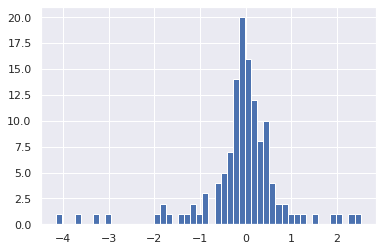

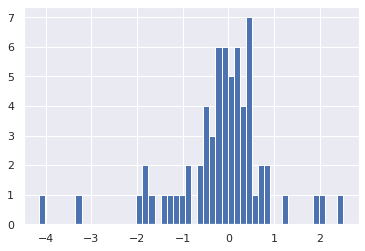

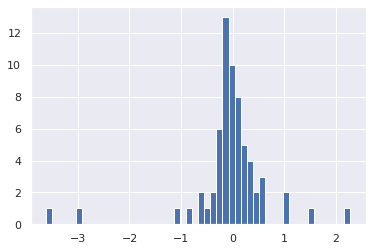

In [92]:
two_digit_ones = hstack((digit_ones[0], digit_ones[1]))
print(two_digit_ones.shape)
# plot the histogram
pyplot.hist(two_digit_ones, bins=50)
pyplot.show()

pyplot.hist(digit_ones[0], bins=50)
pyplot.show()

pyplot.hist(digit_ones[1], bins=50)
pyplot.show()

In [54]:
# fit density
model = KernelDensity(bandwidth=0.401412536529284, kernel='gaussian')
# two_digit_ones = two_digit_ones.reshape((len(two_digit_ones), 1))
model.fit(new_x)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.401412536529284,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

> logprob model =  [-316.68728189 -373.13349898 -181.02892192 -215.04523992 -217.42065165
 -325.48876266]
> probabilities exp =  [2.91380838e-138 8.91621183e-163 2.39959609e-079 4.04612171e-094
 3.76193022e-095 4.38557410e-142]
> test prob percent =  2.9138083761047055e-138
 test ini lbh kecil daripada 2e-19


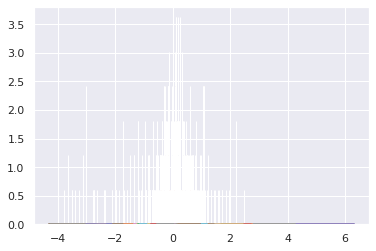

In [78]:
logprob = model.score_samples(digit_x_test)
print("> logprob model = ", logprob)
probabilities = exp(logprob)
print("> probabilities exp = ", probabilities)
# test = (probabilities[0]-1)*100
test = probabilities[0]
print("> test prob percent = ", float(test))
th = 0.0000000000000000002
if float(test) < th:
    print(" test ini lbh kecil daripada", th)
else:
    print(" test ini lbh BEESAAARRR daripada", th) 

# plot the histogram and pdf
pyplot.hist(new_x, bins=50, density=True)
pyplot.plot(digit_x_test[:], probabilities)
pyplot.show()

> logprob model =  [-2.96001637 -2.96001637 -2.96001637 -2.96001637 -2.96001637]
> probabilities exp =  [0.05181807 0.05181807 0.05181807 0.05181807 0.05181807]
> test prob percent =  0.051818068780222826
 test ini lbh BEESAAARRR daripada 0.002


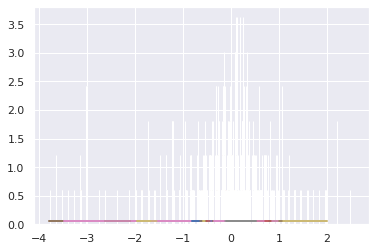

In [81]:
logprob = model.score_samples(digit_ones_test)
print("> logprob model = ", logprob)
probabilities = exp(logprob)
print("> probabilities exp = ", probabilities)
# test = (probabilities[0]-1)*100
test = probabilities[0]
print("> test prob percent = ", float(test))
th = 0.002
if float(test) < th:
    print(" test ini lbh kecil daripada", th)
else:
    print(" test ini lbh BEESAAARRR daripada", th) 

# plot the histogram and pdf
pyplot.hist(new_x, bins=50, density=True)
pyplot.plot(digit_ones_test[:], probabilities)
pyplot.show()

In [85]:
new_y = []
for i in range(len(new_x)):
    new_y.append(1)
new_y = np.array(new_y)
new_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [98]:
from hw5.libs.algo.KDEClassifier import KDEClassifier

dataset = Dataset(train_data=80, test_data=20)
aX_train, aY_train, aX_test, aY_test = dataset.get_dataset()

# kde = KDEClassifier(bandwidth=0.401412536529284)
kde = KDEClassifier(bandwidth=0.01)
# fit density
# kde.fit(new_x, new_y)
kde.fit(aX_train, aY_train)
# predict probability
# prob = kde.predict(digit_ones_test)
prob = kde.predict(aX_test)
print("> prob = ", prob)
print("> aY_test = ", aY_test)

accuracy = np.sum(prob == Y_test).astype(float) / len(Y_test)
print("> accuracy = ", accuracy)

> prob =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
> aY_test =  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
> accuracy =  0.15


/home/ardi/devel/nctu/mlsp/hw5/libs/algo/KDEClassifier.py:45: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)
